In [1]:
import time

import numpy as np
import cv2
from scipy.spatial import Delaunay
import knn

import matplotlib.pyplot as plt

In [2]:
DEFINED = 0
UNDEFINED = 255

origin = (15, 15)
mask = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE)

In [3]:
def display_neighbors(mask: np.ndarray, origin: tuple, neighbors: list[tuple]):
    fig, axis = plt.subplots(1, 1, figsize=(6,6))
    axis.imshow(mask, cmap="Greys", alpha=0.5)
    axis.scatter(y=[origin[0]], x=[origin[1]], c="red")
    axis.scatter(y=[n[0] for n in neighbors], x=[n[1] for n in neighbors])
    
    axis.set_xticks([])
    axis.set_yticks([])

    plt.show()

In [4]:
def euclidean_distance(point1: tuple[int, int], point2: tuple[int, int]) -> float:
    p1_y, p1_x = point1
    p2_y, p2_x = point2

    return np.sqrt((p2_y - p1_y) ** 2 + (p2_x - p1_x) ** 2)

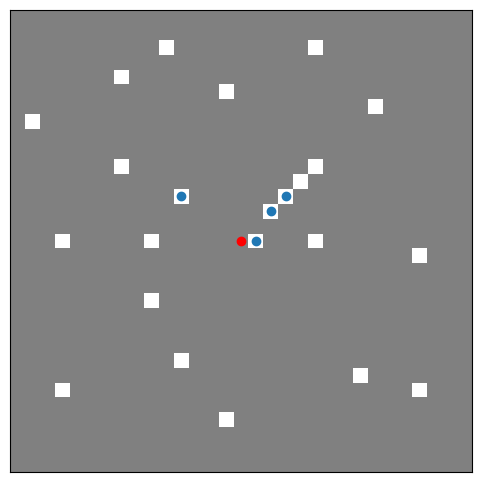

In [5]:
def nn_bruteforce(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    height, width = mask.shape

    for y in range(height):
        for x in range(width):
            if mask[y, x] == DEFINED:
                neighbors.append((y, x, euclidean_distance(origin, (y, x))))
                
    neighbors = sorted(neighbors, key=lambda item: item[2])
    return neighbors[0: k]

neighbors = nn_bruteforce(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

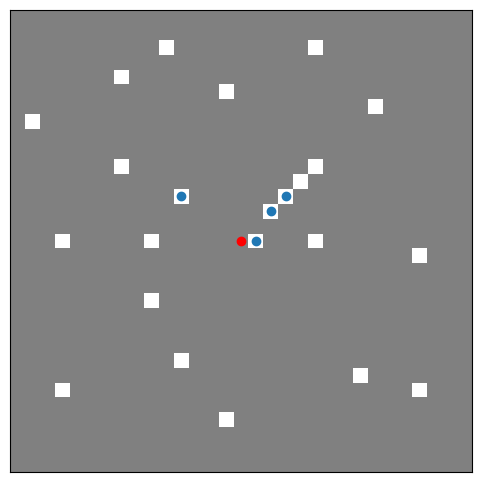

In [6]:
def nn_bruteforce_numpy(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    candidates = np.argwhere(mask == DEFINED)
    for y, x in candidates:
        neighbors.append((y, x, euclidean_distance(origin, (y, x))))

    neighbors = sorted(neighbors, key=lambda item: item[2])
    return neighbors[0: k]

neighbors = nn_bruteforce(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

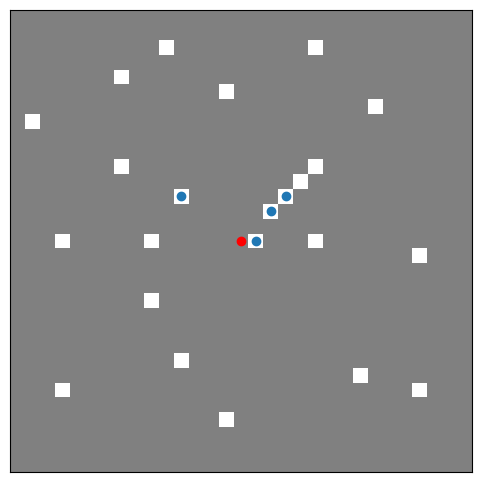

In [7]:
def expand(tri: Delaunay, index: int, queue: list, visited: list) -> None:
    neighbor_indices = tri.vertex_neighbor_vertices[1][tri.vertex_neighbor_vertices[0][index]: tri.vertex_neighbor_vertices[0][index+1]]
    for neighbor_index in neighbor_indices:
        if (neighbor_index not in visited):
            queue.append(neighbor_index)
            visited.append(neighbor_index)


def nn_delaunay(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors, queue, visited  = [], [], []
    radius = np.inf
    tri = Delaunay(np.argwhere(mask == DEFINED), incremental=True)  # do this only once later
    tri.add_points([origin])

    start_node_index = np.argwhere((tri.points == origin).all(axis=1)).item()
    expand(tri, start_node_index, queue, visited)
    visited.append(start_node_index)
    while queue:
        index = queue.pop(0)
        
        p_y, p_x = tri.points[index]
        d = euclidean_distance(origin, (p_y, p_x))
        if d > radius:
            continue

        neighbors.append((p_y, p_x, d))
        neighbors = sorted(neighbors, key=lambda item: item[2])
        neighbors = neighbors[0: k]
        if len(neighbors) == k:
            radius = neighbors[-1][2]

        expand(tri, index, queue, visited)

    # fig, axis = plt.subplots(1, 1, figsize=(6,6))
    # axis.imshow(mask, cmap="Greys", alpha=0.5)
    # axis.triplot(tri.points[:,1], tri.points[:,0], tri.simplices)
    # axis.scatter(y=[origin[0]], x=[origin[1]], c="red")
    # plt.show()

    return neighbors

neighbors = nn_delaunay(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

In [8]:
# mask = np.random.rand(400 * 400).reshape(400, 400)
# mask = np.where(mask < 0.01, 0, 255)
# neighbors = nn_delaunay(mask, (200, 200), 4)
# display_neighbors(mask, (200, 200), neighbors)

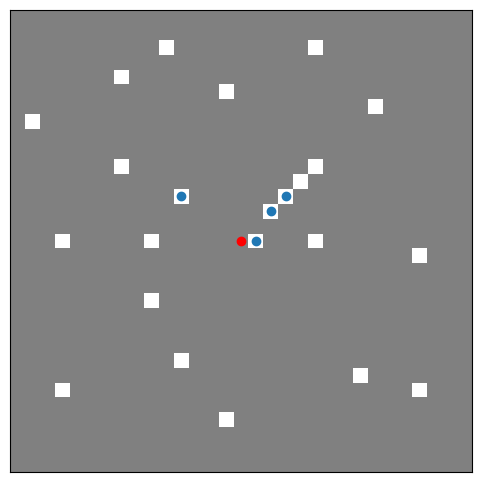

In [9]:
def nn_quadratic(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = []
    origin_y, origin_x = origin
    height, width = mask.shape

    max_distance = max(origin_y, height - origin_y, origin_x, width - origin_x)

    for distance in range(1, max_distance):
        y_t, y_b = origin_y - distance, origin_y + distance
        x_l, x_r = origin_x - distance, origin_x + distance

        for y in range(y_t, y_b + 1):
            if 0 <= y < height:
                if x_l >= 0 and mask[y, x_l] == DEFINED:
                    neighbors.append((y, x_l, euclidean_distance(origin, (y, x_l))))
                if x_r < width and mask[y, x_r] == DEFINED:
                    neighbors.append((y, x_r, euclidean_distance(origin, (y, x_r))))

        for x in range(x_l + 1, x_r):
            if 0 <= x < width:
                if y_t >= 0 and mask[y_t, x] == DEFINED:
                    neighbors.append((y_t, x, euclidean_distance(origin, (y_t, x))))
                if y_b < height and mask[y_b, x] == DEFINED:
                    neighbors.append((y_b, x, euclidean_distance(origin, (y_b, x))))

        if len(neighbors) >= k:
            neighbors = sorted(neighbors, key=lambda item: item[2])
            neighbors = neighbors[0 :k]
            if neighbors[-1][2] < distance:
                break

    return neighbors

neighbors = nn_quadratic(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

31.41592653589793


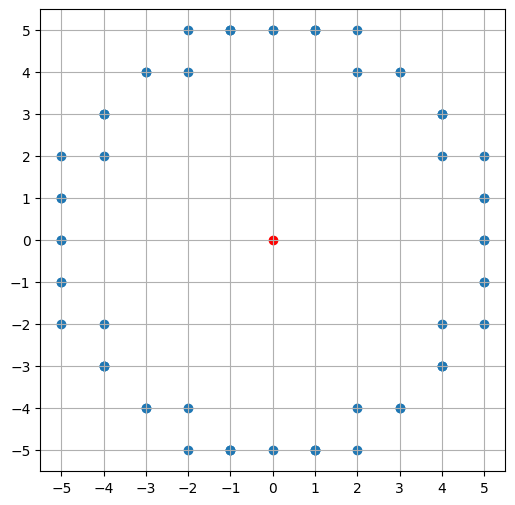

In [97]:
fig, axis = plt.subplots(1, 1, figsize=(6, 6))
radius = 5
print(2 * np.pi * radius)
discretization = np.linspace(0, 2, int(4 * np.pi * radius + 1)) * np.pi
Y = np.round(radius * np.cos(discretization)).astype(int)
X = np.round(radius * np.sin(discretization)).astype(int)
# Y = (radius * np.cos(discretization)).astype(int)
# X = (radius * np.sin(discretization)).astype(int)
# Y = radius * np.cos(discretization)
# X = radius * np.sin(discretization)

# for y, x in zip(radius * np.cos(discretization), radius * np.sin(discretization)):
#     print(y, x)

axis.scatter(x=0, y=0, c="r")
axis.scatter(x=X, y=Y)
axis.set_yticks(np.arange(-radius, radius + 1, 1))
axis.set_xticks(np.arange(-radius, radius + 1, 1))
plt.grid()
plt.show()

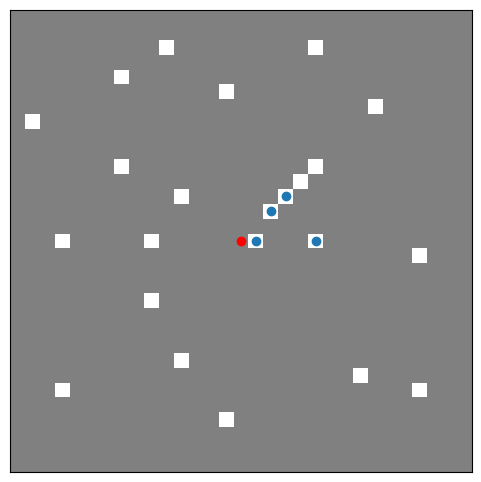

In [98]:
def nn_circle(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    neighbors = set()
    origin_y, origin_x = origin
    height, width = mask.shape

    furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))

    for distance in range(1, furthest_pixel):
        discretization = np.linspace(0, 2, int(4 * np.pi * distance + 1)) * np.pi
        Y = np.round(distance * np.cos(discretization) + origin_y).astype(int)
        X = np.round(distance * np.sin(discretization) + origin_x).astype(int)

        for y, x in zip(Y, X):
            if 0 <= y < height and 0 <= x < width and mask[y, x] == DEFINED:
                neighbors.add((y, x))
                if len(neighbors) == k:
                    return list(neighbors)

    return list(neighbors)

neighbors = nn_circle(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

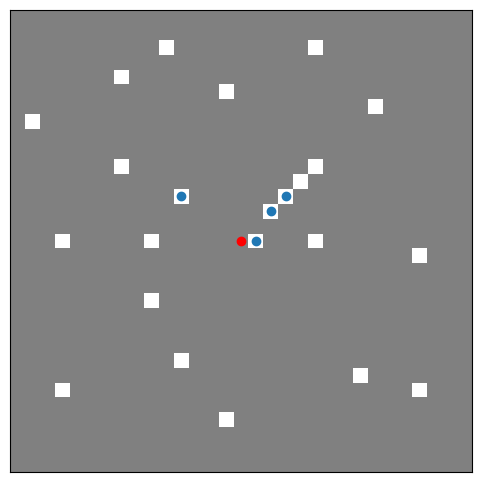

In [99]:
def nn_circle_opt(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    height, width = mask.shape

    furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))

    discretization = np.linspace(0, 2, 360) * np.pi
    neighbors = knn.nn_circular(mask, origin, discretization, furthest_pixel, k)

    return list(neighbors)

neighbors = nn_circle_opt(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

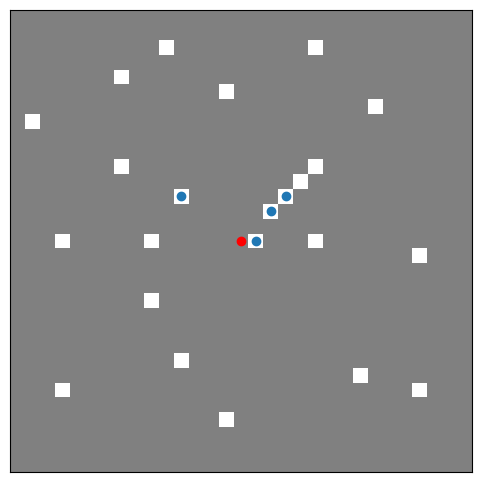

In [100]:
neighbors = knn.nn_circular_native(mask, origin, 4)
display_neighbors(mask, origin, neighbors)

In [101]:
import unittest

class TestNN(unittest.TestCase):

    def get_default_mask_params(self):
        origin = (15, 15)
        mask = cv2.imread("data/knn_unittest.png", cv2.IMREAD_GRAYSCALE)
        k = 4
        gt = [(15, 16), (15, 20), (13, 17), (12, 18), (12, 11)]

        return mask, origin, k, gt
    
    def get_quadratic_mask_params_corner(self):
        origin = (15, 15)
        mask = np.full((31, 31), 255)
        mask[1, 1] = 0
        mask[29, 29] = 0
        mask[15, 0] = 0
        mask[15, 30] = 0
        k = 2
        gt = [(15, 0), (15, 30)]

        return mask, origin, k, gt
    
    def get_circle_mask_params_corner(self):
        origin = (15, 15)
        mask = np.full((31, 31), 255)
        mask[0, 0] = 0
        mask[30, 30] = 0
        k = 2
        gt = [(0, 0), (30, 30)]

        return mask, origin, k, gt

    def test_bruteforce_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_bruteforce(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_delaunay_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_delaunay(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_quadratic_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_quadratic(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_circle(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_opt_default(self):
        mask, origin, k, gt = self.get_default_mask_params()
        neighbors = nn_circle_opt(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_quadratic_corner(self):
        mask, origin, k, gt = self.get_quadratic_mask_params_corner()
        neighbors = nn_quadratic(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_corner(self):
        mask, origin, k, gt = self.get_circle_mask_params_corner()
        neighbors = nn_circle(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_opt_corner(self):
        mask, origin, k, gt = self.get_circle_mask_params_corner()
        neighbors = nn_circle_opt(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))

    def test_circle_native_corner(self):
        mask, origin, k, gt = self.get_circle_mask_params_corner()
        neighbors = knn.nn_circular_native(mask, origin, k)
        neighbors = [(n[0], n[1]) for n in neighbors]
        self.assertTrue(set(gt).issuperset(set(neighbors)))


unittest.main(argv=[""], verbosity=1, exit=False)

.........
----------------------------------------------------------------------
Ran 9 tests in 0.008s

OK


In [106]:
%load_ext line_profiler
%load_ext timeit

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The timeit module is not an IPython extension.


In [110]:
def test_nn_general(shape, fill_factor, k,  nn_f):
    mask = np.random.rand(shape[0] * shape[1]).reshape(shape)
    mask = np.where(mask < fill_factor, 0, 255)
    origin = (shape[0] // 2, shape[1] // 2)
    mask[origin[0], origin[1]] = UNDEFINED
    # t1 = time.time()
    nn_f(mask, origin, k)
    # print(f"{nn_f}: {time.time() - t1}; {shape} - {fill_factor}")

In [22]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_bruteforce)

<function nn_bruteforce at 0x75ecd9770900>: 0.02813124656677246; (400, 400) - 0.001
<function nn_bruteforce at 0x75ecd9770900>: 0.01988816261291504; (400, 400) - 0.01
<function nn_bruteforce at 0x75ecd9770900>: 0.08272528648376465; (400, 400) - 0.1
<function nn_bruteforce at 0x75ecd9770900>: 0.06925773620605469; (400, 400) - 0.25
<function nn_bruteforce at 0x75ecd9770900>: 0.13063406944274902; (400, 400) - 0.5
<function nn_bruteforce at 0x75ecd9770900>: 0.1194615364074707; (1000, 1000) - 0.001
<function nn_bruteforce at 0x75ecd9770900>: 0.12510037422180176; (1000, 1000) - 0.01
<function nn_bruteforce at 0x75ecd9770900>: 0.24875283241271973; (1000, 1000) - 0.1
<function nn_bruteforce at 0x75ecd9770900>: 0.5094528198242188; (1000, 1000) - 0.25
<function nn_bruteforce at 0x75ecd9770900>: 0.9012181758880615; (1000, 1000) - 0.5
<function nn_bruteforce at 0x75ecd9770900>: 0.510948657989502; (2000, 2000) - 0.001
<function nn_bruteforce at 0x75ecd9770900>: 0.5187845230102539; (2000, 2000) - 0.

In [113]:
%timeit -n 10 -r 5 test_nn_general((2000, 2000), 0.01, 10, nn_bruteforce)

551 ms ± 5.24 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [23]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_bruteforce_numpy)

<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.0008330345153808594; (400, 400) - 0.001
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.005261421203613281; (400, 400) - 0.01
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.03521227836608887; (400, 400) - 0.1
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.08907485008239746; (400, 400) - 0.25
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.16640663146972656; (400, 400) - 0.5
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.0038480758666992188; (1000, 1000) - 0.001
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.02217388153076172; (1000, 1000) - 0.01
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.20867061614990234; (1000, 1000) - 0.1
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.5229966640472412; (1000, 1000) - 0.25
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 1.0895230770111084; (1000, 1000) - 0.5
<function nn_bruteforce_numpy at 0x75ecd97d7d80>: 0.016497373580932617; (2000, 2000) - 0.001
<funct

In [24]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_delaunay)

<function nn_delaunay at 0x75ecd436cb80>: 0.0012316703796386719; (400, 400) - 0.001
<function nn_delaunay at 0x75ecd436cb80>: 0.005853414535522461; (400, 400) - 0.01
<function nn_delaunay at 0x75ecd436cb80>: 0.06623649597167969; (400, 400) - 0.1
<function nn_delaunay at 0x75ecd436cb80>: 0.19282984733581543; (400, 400) - 0.25
<function nn_delaunay at 0x75ecd436cb80>: 0.5216608047485352; (400, 400) - 0.5
<function nn_delaunay at 0x75ecd436cb80>: 0.00540614128112793; (1000, 1000) - 0.001
<function nn_delaunay at 0x75ecd436cb80>: 0.0380709171295166; (1000, 1000) - 0.01
<function nn_delaunay at 0x75ecd436cb80>: 0.555994987487793; (1000, 1000) - 0.1
<function nn_delaunay at 0x75ecd436cb80>: 2.3528940677642822; (1000, 1000) - 0.25
<function nn_delaunay at 0x75ecd436cb80>: 5.670719385147095; (1000, 1000) - 0.5
<function nn_delaunay at 0x75ecd436cb80>: 0.0231478214263916; (2000, 2000) - 0.001
<function nn_delaunay at 0x75ecd436cb80>: 0.16823863983154297; (2000, 2000) - 0.01
<function nn_delauna

In [25]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_quadratic)

<function nn_quadratic at 0x75ecd436d760>: 0.0012328624725341797; (400, 400) - 0.001
<function nn_quadratic at 0x75ecd436d760>: 0.00023818016052246094; (400, 400) - 0.01
<function nn_quadratic at 0x75ecd436d760>: 6.628036499023438e-05; (400, 400) - 0.1
<function nn_quadratic at 0x75ecd436d760>: 5.6743621826171875e-05; (400, 400) - 0.25
<function nn_quadratic at 0x75ecd436d760>: 4.9114227294921875e-05; (400, 400) - 0.5
<function nn_quadratic at 0x75ecd436d760>: 0.0011248588562011719; (1000, 1000) - 0.001
<function nn_quadratic at 0x75ecd436d760>: 0.00025343894958496094; (1000, 1000) - 0.01
<function nn_quadratic at 0x75ecd436d760>: 7.414817810058594e-05; (1000, 1000) - 0.1
<function nn_quadratic at 0x75ecd436d760>: 4.9114227294921875e-05; (1000, 1000) - 0.25
<function nn_quadratic at 0x75ecd436d760>: 4.2438507080078125e-05; (1000, 1000) - 0.5
<function nn_quadratic at 0x75ecd436d760>: 0.0009567737579345703; (2000, 2000) - 0.001
<function nn_quadratic at 0x75ecd436d760>: 0.00025844573974

In [104]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_circle)

<function nn_circle at 0x71b39738ad40>: 0.006097316741943359; (400, 400) - 0.001
<function nn_circle at 0x71b39738ad40>: 0.0026061534881591797; (400, 400) - 0.01
<function nn_circle at 0x71b39738ad40>: 0.00021839141845703125; (400, 400) - 0.1
<function nn_circle at 0x71b39738ad40>: 0.00017189979553222656; (400, 400) - 0.25
<function nn_circle at 0x71b39738ad40>: 0.00014138221740722656; (400, 400) - 0.5
<function nn_circle at 0x71b39738ad40>: 0.008285284042358398; (1000, 1000) - 0.001
<function nn_circle at 0x71b39738ad40>: 0.0008051395416259766; (1000, 1000) - 0.01
<function nn_circle at 0x71b39738ad40>: 0.00015878677368164062; (1000, 1000) - 0.1
<function nn_circle at 0x71b39738ad40>: 0.0001399517059326172; (1000, 1000) - 0.25
<function nn_circle at 0x71b39738ad40>: 0.00010037422180175781; (1000, 1000) - 0.5
<function nn_circle at 0x71b39738ad40>: 0.006662845611572266; (2000, 2000) - 0.001
<function nn_circle at 0x71b39738ad40>: 0.0012319087982177734; (2000, 2000) - 0.01
<function nn_

In [117]:
%timeit -n 10 -r 5 test_nn_general((2000, 2000), 0.1, 10, nn_circle)

26.2 ms ± 552 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [27]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, nn_circle_opt)

<function nn_circle_opt at 0x75ecd43653a0>: 0.00022101402282714844; (400, 400) - 0.001
<function nn_circle_opt at 0x75ecd43653a0>: 0.00010418891906738281; (400, 400) - 0.01
<function nn_circle_opt at 0x75ecd43653a0>: 7.772445678710938e-05; (400, 400) - 0.1
<function nn_circle_opt at 0x75ecd43653a0>: 6.914138793945312e-05; (400, 400) - 0.25
<function nn_circle_opt at 0x75ecd43653a0>: 6.246566772460938e-05; (400, 400) - 0.5
<function nn_circle_opt at 0x75ecd43653a0>: 0.00021266937255859375; (1000, 1000) - 0.001
<function nn_circle_opt at 0x75ecd43653a0>: 0.00011134147644042969; (1000, 1000) - 0.01
<function nn_circle_opt at 0x75ecd43653a0>: 6.628036499023438e-05; (1000, 1000) - 0.1
<function nn_circle_opt at 0x75ecd43653a0>: 7.081031799316406e-05; (1000, 1000) - 0.25
<function nn_circle_opt at 0x75ecd43653a0>: 6.175041198730469e-05; (1000, 1000) - 0.5
<function nn_circle_opt at 0x75ecd43653a0>: 0.0002257823944091797; (2000, 2000) - 0.001
<function nn_circle_opt at 0x75ecd43653a0>: 0.0001

In [118]:
%timeit -n 10 -r 5 test_nn_general((2000, 2000), 0.1, 10, nn_circle_opt)

25.6 ms ± 542 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [28]:
for shape in [(400, 400), (1000, 1000), (2000, 2000)]:
    for fill_factor in [0.001, 0.01, 0.1, 0.25, 0.5]:
        test_nn_general(shape, fill_factor, 10, knn.nn_circular_native)

<built-in method nn_circular_native of PyCapsule object at 0x75ecffe34cc0>: 0.0002071857452392578; (400, 400) - 0.001
<built-in method nn_circular_native of PyCapsule object at 0x75ecffe34cc0>: 6.866455078125e-05; (400, 400) - 0.01
<built-in method nn_circular_native of PyCapsule object at 0x75ecffe34cc0>: 2.6702880859375e-05; (400, 400) - 0.1
<built-in method nn_circular_native of PyCapsule object at 0x75ecffe34cc0>: 1.7404556274414062e-05; (400, 400) - 0.25
<built-in method nn_circular_native of PyCapsule object at 0x75ecffe34cc0>: 1.7881393432617188e-05; (400, 400) - 0.5
<built-in method nn_circular_native of PyCapsule object at 0x75ecffe34cc0>: 0.00020647048950195312; (1000, 1000) - 0.001
<built-in method nn_circular_native of PyCapsule object at 0x75ecffe34cc0>: 5.9604644775390625e-05; (1000, 1000) - 0.01
<built-in method nn_circular_native of PyCapsule object at 0x75ecffe34cc0>: 2.6464462280273438e-05; (1000, 1000) - 0.1
<built-in method nn_circular_native of PyCapsule object at 

In [127]:
shape = (10000, 10000)
mask_2 = np.random.rand(shape[0] * shape[1]).reshape(shape)
mask_2 = np.where(mask_2 < 0.001, 0, 255)
origin_2 = (mask_2.shape[0] // 2, mask_2.shape[1] // 2)
mask_2[origin_2[0], origin_2[1]] = UNDEFINED

%timeit -n 100 -r 10 nn_circle(mask_2, origin_2, 10)
%timeit -n 100 -r 10 nn_circle_opt(mask_2, origin_2, 10)
%timeit -n 100 -r 10 knn.nn_circular_native(mask_2, origin_2, 10)

12 ms ± 78.1 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
208 µs ± 1.86 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
249 µs ± 1.61 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [29]:
mask = np.random.rand(1000 * 1000).reshape((1000, 1000))
mask = np.where(mask < 0.01, 0, 255)
origin = (500, 500)
k = 4

In [30]:
%lprun -f nn_bruteforce nn_bruteforce(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.390126 s
File: /tmp/ipykernel_62749/1595391075.py
Function: nn_bruteforce at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_bruteforce(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1        631.0    631.0      0.0      neighbors = []
     3         1       1022.0   1022.0      0.0      height, width = mask.shape
     4                                           
     5      1001     123226.0    123.1      0.0      for y in range(height):
     6   1001000  131366341.0    131.2     33.7          for x in range(width):
     7   1000000  238805389.0    238.8     61.2              if mask[y, x] == DEFINED:
     8     10035   16105560.0   1604.9      4.1                  neighbors.append((y, x, euclidean_distance(origin, (y, x))))
     9                                                           
    10         1    3721736.0    4e+06      1.0      neighb

In [31]:

%lprun -f nn_bruteforce_numpy nn_bruteforce_numpy(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.0332995 s
File: /tmp/ipykernel_62749/2638980425.py
Function: nn_bruteforce_numpy at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_bruteforce_numpy(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1        391.0    391.0      0.0      neighbors = []
     3         1    2483519.0    2e+06      7.5      candidates = np.argwhere(mask == DEFINED)
     4     10036    9031587.0    899.9     27.1      for y, x in candidates:
     5     10035   18019033.0   1795.6     54.1          neighbors.append((y, x, euclidean_distance(origin, (y, x))))
     6                                           
     7         1    3763705.0    4e+06     11.3      neighbors = sorted(neighbors, key=lambda item: item[2])
     8         1       1283.0   1283.0      0.0      return neighbors[0: k]

In [32]:
%lprun -f nn_delaunay nn_delaunay(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.132731 s
File: /tmp/ipykernel_62749/806411042.py
Function: nn_delaunay at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def nn_delaunay(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
    10         1        541.0    541.0      0.0      neighbors, queue, visited  = [], [], []
    11         1        621.0    621.0      0.0      radius = np.inf
    12         1  124904075.0    1e+08     94.1      tri = Delaunay(np.argwhere(mask == DEFINED), incremental=True)  # do this only once later
    13         1    5098563.0    5e+06      3.8      tri.add_points([origin])
    14                                           
    15         1     239529.0 239529.0      0.2      start_node_index = np.argwhere((tri.points == origin).all(axis=1)).item()
    16         1    2339569.0    2e+06      1.8      expand(tri, start_node_index, queue, visited)
    17         1        261.0    261.0 

In [33]:
%lprun -f nn_quadratic nn_quadratic(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.000256268 s
File: /tmp/ipykernel_62749/3799269253.py
Function: nn_quadratic at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_quadratic(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1        421.0    421.0      0.2      neighbors = []
     3         1        200.0    200.0      0.1      origin_y, origin_x = origin
     4         1        671.0    671.0      0.3      height, width = mask.shape
     5                                           
     6         1       1022.0   1022.0      0.4      max_distance = max(origin_y, height - origin_y, origin_x, width - origin_x)
     7                                           
     8         9       1932.0    214.7      0.8      for distance in range(1, max_distance):
     9         9       1824.0    202.7      0.7          y_t, y_b = origin_y - distance, origin_y + distance
    10         9       1533.0   

In [129]:
%lprun -f nn_circle nn_circle(mask, origin, 4)

Timer unit: 1e-09 s

Total time: 0.00070843 s
File: /tmp/ipykernel_9770/3619931796.py
Function: nn_circle at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_circle(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1        912.0    912.0      0.1      neighbors = set()
     3         1        291.0    291.0      0.0      origin_y, origin_x = origin
     4         1       2073.0   2073.0      0.3      height, width = mask.shape
     5                                           
     6         1      38512.0  38512.0      5.4      furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))
     7                                           
     8         5       1802.0    360.4      0.3      for distance in range(1, furthest_pixel):
     9         5     184015.0 

In [35]:
%lprun -f nn_circle_opt nn_circle_opt(mask, origin, k)

Timer unit: 1e-09 s

Total time: 0.000118802 s
File: /tmp/ipykernel_62749/679757888.py
Function: nn_circle_opt at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def nn_circle_opt(mask: np.ndarray, origin: tuple, k: int) -> list[tuple]:
     2         1        841.0    841.0      0.7      height, width = mask.shape
     3                                           
     4         1      17713.0  17713.0     14.9      furthest_pixel = round(max(euclidean_distance(origin, (0, 0)), euclidean_distance(origin, (height, 0)), euclidean_distance(origin, (0, width)), euclidean_distance(origin, (height, width))))
     5                                           
     6         1      43662.0  43662.0     36.8      discretization = np.linspace(0, 2, 360) * np.pi
     7         1      55434.0  55434.0     46.7      neighbors = knn.nn_circular(mask, origin, discretization, furthest_pixel, k)
     8                               